![](https://miro.medium.com/max/530/1*bUZKHfAugVeXAkl0TGClCA.png)
# Welcome to Practical Deep Learning for Coders (for 2.0)! 
## Originally taught by Jeremy Howard

## Moderated by Zachary Mueller

# 3nd Edition

###Minimum Requirements: 


*   A want to learn
*   Some basic coding skills (or ability to learn quickly)
*   High School math


###From the words of Jeremy:
### "The world needs everyone to be involved with AI, no matter how unlikely your background."

![](https://mediad.publicbroadcasting.net/p/shared/npr/styles/x_large/nprshared/201811/524707840.jpg)


# What is fastai?

The fastai library is an **open-source** state-of-the-art deep neural network library aided to help prepare models on a standard pipeline for deployment or research in a way that is simple enough for most people to understand and use with ease. [Github](https://github.com/fastai/fastai)

# What is this course?

This set of notebooks is geared to both introduce the fastai library and to show the major differences/new API changes with 2.0.

# What we will be doing today:
 * Setting up the Colab environment
 * Getting the fastai libraries
 * Creating our model
 * Using a basic dataset to make a classifier

# Why Google Colaboratory?


*   Free access to GPU's
*   Hardest part is setting it up

## Setting up Google Colab

1. Go to 'Google Drive'
2. Select 'New'
3. Select 'More'
4. Select 'Connect more apps'
5. Search for 'Google Colab'
6. Select 'Connect'
7. Go back to 'More' and add 'Google Colaboratory'


![alt text](https://i.imgur.com/n4mQ2qj.png)

## Changing our processer to a GPU

* 'Runtime'
* 'Change runtime type'
* 'Runtime type' should be 'Python 3'
* 'Hardware accelerator' should be 'GPU' 

## Initial Run Warning (For pulling from GitHub)

***If you get a pop up saying 'Warning: This notebook was not authored by Google,' check 'Reset all runtimes before running' and click 'Run Anyway'***

![alt text](https://course-v3.fast.ai/images/colab/02.png)

## Saving your work

For now this will just save the notebook on their cloud, we will look next week how to utilize your Google Drives!

![alt text](https://course-v3.fast.ai/images/colab/09.png)

# Now for the Fun Part

Since we are using the 2.0 library, we will need to install the 2.0 library along with PyTorch 1.3!

In [0]:
!pip3 install torch===1.3.0 torchvision===0.4.1 -f https://download.pytorch.org/whl/torch_stable.html
!pip install git+https://github.com/fastai/fastai_dev > /dev/null
!pip install Pillow --upgrade

Now we can import the `fastai2` libraries (fastai 2.0!)

For today we will be using the `basics` library (which calls the `data`, `optimizer`, `learner`, `metrics`, and `interp` libraries), the `callback` library, and the `vision` library

In [0]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

**fastai supports 4 datatypes:**
* Computer vision (fastai.vision)
* Natural language text (fastai.text)
* Tabular Data (fastai.tabular)
* Collaborative filtering (fastai.collab) * not taught

## Looking at Data

We will use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al, 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which has images of 12 cat and 25 dog breeds. The model we will build must be able to differentiate between the 37 different species. In the paper, their best accuracy in 2012 was 59.21% using a specific detection method that had a "Image", "Head", and "Body" model for the photos. **WE** will be trying to classify them via only a full image of the species.

In [0]:
help(untar_data)

Help on function untar_data in module fastai2.data.external:

untar_data(url, fname=None, dest=None, c_key='data', force_download=False, extract_func=<function tar_extract at 0x7f0b647aa510>)
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [0]:
untar_data??

This will download our dataset. **However** with the new 2.0 API we no longer want to do this. Let's compare. These are the steps 1.0 had us go through:

In [0]:
### DO NOT RUN! JUST FOR SHOW OF HOW THE 1.0 API LOOKED ###
path = untar_data(URLs.PETS)
path_img = path/'images'
fnames = get_image_files(path_img)
pat = re.compile(r'/([^/]+)_\d+.jpg$')
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224)
data = data.normalize(imagenet_stats)

In [0]:
np.random.seed(2)

For those unaccustomed to the 1.0 library you can ignore this and jump to how we do it now, but basically we now have a **Pipeline** to lay out the groundwork for doing the above. 

A `Pipeline` does exactly what it sounds like. We lay down a plan for how we want the data to go through when training our model! Let's think about how this conceptually looks from start to finish. What are we looking at?

1. Our inputs are of `PILImage` and our outputs are a `Category` (a classification problem!)
2. How do we want to get our filenames? `get_image_files` (just like before)
3. How do we want to split our data between training and validation? Randomly. (this was doing this before in 1.0 we just never specified it, it was defualted to an 80/20 split)
4. How do we want to label our data? via a regex label like before.

Let's look at how we would write that!

In [0]:
pets = DataBlock(types=(PILImage, Category),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.jpg$'))

Starting to see the similarities? What you may notice is this is just a **plan** of how to get our data and use it. No `DataBunch` has been made yet, and we haven't declared the transforms! That's the next step, let's do that!

In [0]:
dbunch = pets.databunch(untar_data(URLs.PETS)/"images", item_tfms=RandomResizedCrop(460, min_scale=0.75), bs=32,
                        batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize(*imagenet_stats)])

There is a **LOT** that just happened there. Let's break it down. 

1. When we call `.databunch()` to a `DataBlock` pipeline, we first pass in where our data is going to be (our `untar_data` function)
2. Next we declare what transforms are happening at an `item` level (when each item is called in the batch) with `item_tfms`
3. We have our batch size like usual
4. We then decalre the transforms that happen on a `batch` level, such as resizing to our input size
5. Finally, we `Normalize` our data to `imagenet_stats`.

Overall not *too* different, and if anything it gives us more freedom. Instead of limited to `get_transforms()` like in 1.0 where everything is done at once, now we can split up when certain transforms happen in the process and utilize the GPU for *many* of them!

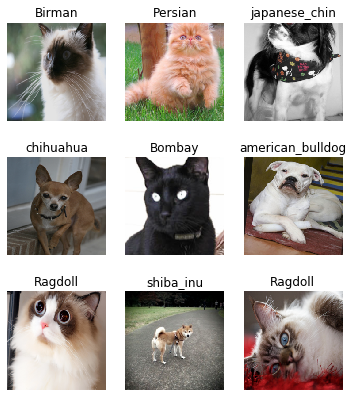

In [0]:
dbunch.show_batch(max_n=9, figsize=(6,7))

If we want to see how many classes we have, and the names of them we can simply call `dbunch.vocab`. The first is the number of classes, the second is the names of our classes. You may notice this looks a bit odd, that's because this `L` is a new invention of Jeremy and Sylvian. Essentially it's a Python list taken to the extreme. 

Before if we wanted to grab the index for the name of a class (eg. our model output 0 as our class), we would need to use `data.c2i` to grab the Class2Index mapping. This is still here, it lives in `dbunch.vocab.o2i`

In [0]:
dbunch.vocab

(#37) [Abyssinian,Bengal,Birman,Bombay,British_Shorthair,Egyptian_Mau,Maine_Coon,Persian,Ragdoll,Russian_Blue...]

In [0]:
dbunch.vocab.o2i

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

## Time to train the model!

We will be using a convolutional neural network backbone and a fully connected head with a single hidden layer as our classifier. Don't worry if thats a bunch of nonsense for now. Right now, just know this: we are piggybacking off of a model to help us classify images into 37 categories.

First, we need to make our Neural Network (fun fact this is *exactly* the same as 1.0!)

In [0]:
from torchvision.models import resnet34

In [0]:
learn = cnn_learner(dbunch, resnet34, pretrained=True, metrics=error_rate)
# data we defined above
# to get your model you want, use models. eg models.resnet50, etc
# metrics is how will we define doing 'good'

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 49.6MB/s]


Now, we can train it! We will train it for four cycles through all our data

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,4.365777,2.586890,0.693505,01:41
1,2.413228,1.239644,0.330853,01:30
2,1.776014,0.956649,0.261164,01:28
3,1.665060,0.910712,0.257104,01:27


In [0]:
learn.save('stage_1')

## Lets look at our results

With the model trained, let's look at where our model might've messed up. What species did it have trouble differentiating between? So long as the misidentifications are not too crazy, our model is actually working.

Then we will plot our confusion matrix, see what specific species it cannot seem to differentiate between

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(dbunch.valid_ds)==len(losses)==len(idxs)

True

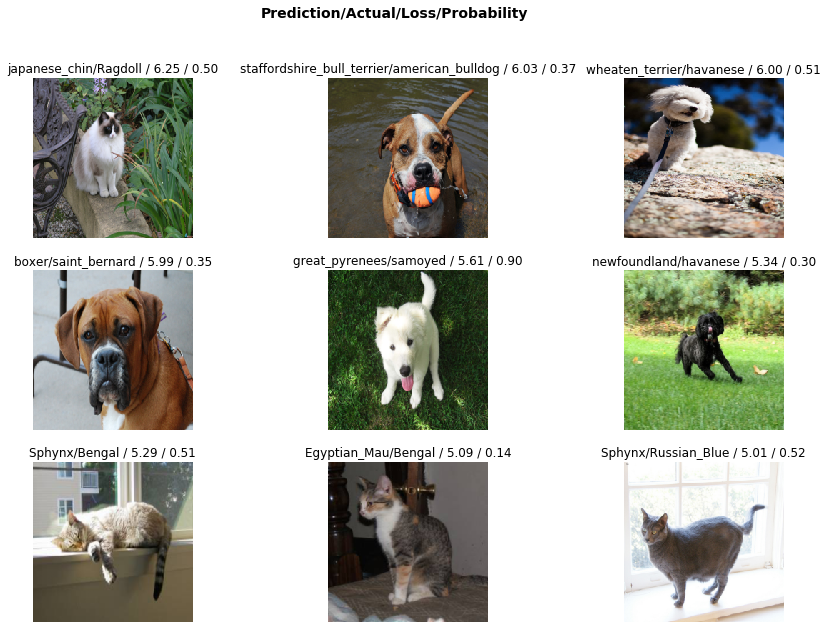

In [0]:
interp.plot_top_losses(9, figsize=(15,10))

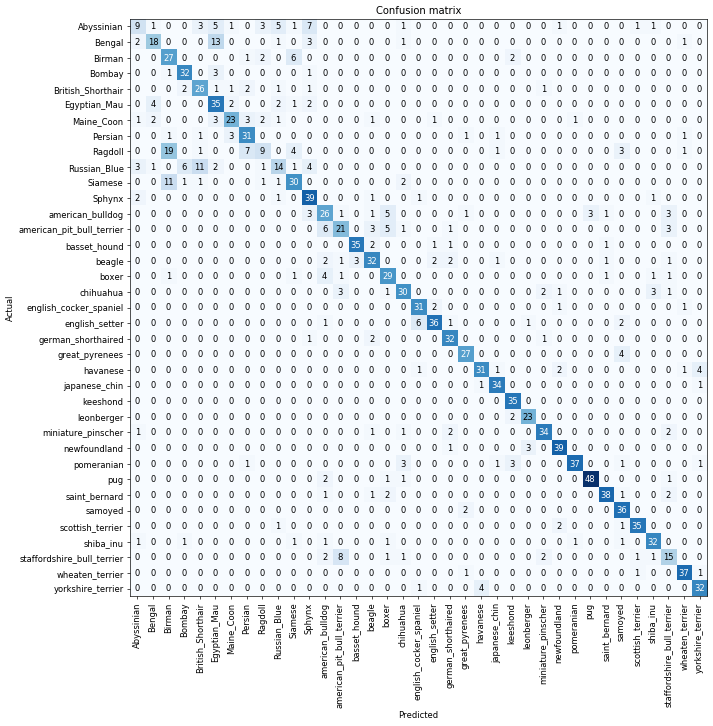

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
interp.most_confused(min_val=3)

[('Ragdoll', 'Birman', 19),
 ('Bengal', 'Egyptian_Mau', 13),
 ('Russian_Blue', 'British_Shorthair', 11),
 ('Siamese', 'Birman', 11),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 8),
 ('Abyssinian', 'Sphynx', 7),
 ('Ragdoll', 'Persian', 7),
 ('Birman', 'Siamese', 6),
 ('Russian_Blue', 'Bombay', 6),
 ('american_pit_bull_terrier', 'american_bulldog', 6),
 ('english_setter', 'english_cocker_spaniel', 6),
 ('Abyssinian', 'Egyptian_Mau', 5),
 ('Abyssinian', 'Russian_Blue', 5),
 ('american_bulldog', 'boxer', 5),
 ('american_pit_bull_terrier', 'boxer', 5),
 ('Egyptian_Mau', 'Bengal', 4),
 ('Ragdoll', 'Siamese', 4),
 ('Russian_Blue', 'Sphynx', 4),
 ('boxer', 'american_bulldog', 4),
 ('great_pyrenees', 'samoyed', 4),
 ('havanese', 'yorkshire_terrier', 4),
 ('yorkshire_terrier', 'havanese', 4),
 ('Abyssinian', 'British_Shorthair', 3),
 ('Abyssinian', 'Ragdoll', 3),
 ('Bengal', 'Sphynx', 3),
 ('Bombay', 'Egyptian_Mau', 3),
 ('Maine_Coon', 'Egyptian_Mau', 3),
 ('Maine_Coon', 'Persia

## Unfreezing our data, fine-tuning, and our learning rates

So, we have the model. Let's fine tune it. First, we need to load our model in.

In [0]:
learn.load('stage_1');

Ok. We have our model. Now we will *unfreeze* and train more

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.438064,0.711434,0.196211,01:42
1,1.065674,0.524764,0.144790,01:41
2,0.896839,0.471412,0.133965,01:41
3,0.863686,0.467536,0.133965,01:41


Now when we `unfreeze`, we unfreeze *all* the layers. So to show how a difference of a proper learning rate looks, let's load in those old weights and try using `lr_find()`

In [0]:
learn.load('stage_1');

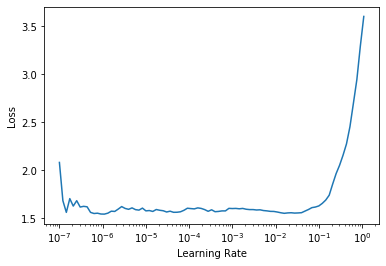

In [0]:
learn.lr_find()

Alright so if we look here, we don't start really spiking our losses until ~10^-2 so a good spot is between 3e-4 and 3e-3, let's do that!

In [0]:
learn.unfreeze()
#lets try again with a new learning rate!
learn.fit_one_cycle(4, lr_max=slice(3e-04, 3e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.852189,0.429214,0.126522,01:42
1,0.712165,0.361900,0.115697,01:42
2,0.551001,0.337063,0.101489,01:41
3,0.588245,0.329899,0.097429,01:41


We can see that picking a proper learning rate can help speed things up!

In [0]:
learn.save('stage_2')

## Now lets try with a resnet50!

If you need to restart your kernel due to memory errors I've attached the `dbunch` code below

In [0]:
from torchvision.models import resnet50

In [0]:
pets = DataBlock(types=(PILImage, Category),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.jpg$'))

dbunch = pets.databunch(untar_data(URLs.PETS)/"images", item_tfms=RandomResizedCrop(460, min_scale=0.75), bs=32,
                        batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize(*imagenet_stats)])

Go ahead and try running the below code yourself. You *should* see a higher increase in accuracy!

Steps to try: 

1. Create your Learner
2. Find a learning rate
3. Fit for 5 epochs
4. Unfreeze and fit for two more

In [0]:
### Try here! ###

## The answer is hidden under here

In [0]:
learn = cnn_learner(data, resnet50, pretrained=True, metrics=error_rate)

In [0]:
learn.lr_find()

In [0]:
learn.fit_one_cycle(5, lr_max=slice(3e-4, 3e-3))

In [0]:
learn.save('resnet50')

In [0]:
learn.load('resnet50')
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=4e-4)

In [0]:
learn.save('resnet50')